<div class="markdown-google-sans">

# <strong>Bayesian Statistics `Regr`</strong>
> #### Gabriel L. S. Silva
</div>

In [68]:
!pip install ucimlrepo --quiet

In [85]:
from sklearn.metrics import silhouette_score
from ucimlrepo import fetch_ucirepo
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import numpy as np
import pymc as pm
import pytensor
import warnings

warnings.filterwarnings('ignore')
pytensor.config.cxx = ''
plt.style.use('bmh')

In [86]:
raw = fetch_ucirepo(id=9)
df = raw.data.features
df['mpg'] = raw.data.targets
df.sample(3)

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
84,97.0,4,88.0,2100,16.5,72,3,27.0
148,116.0,4,75.0,2246,14.0,74,2,26.0
304,91.0,4,69.0,2130,14.7,79,2,37.3


>

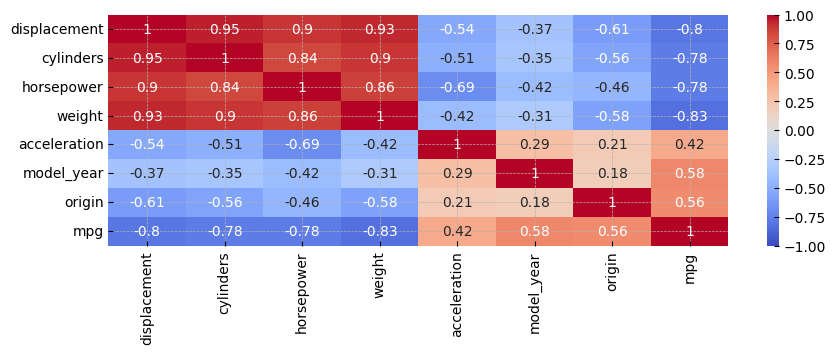

In [87]:
plt.figure(figsize=(10, 3)) # prefiro plot retangular do que quadrado
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1);
# Removerei as variáveis que possuem altissima correlação

In [88]:
df = df.drop(columns=['cylinders', 'horsepower', 'displacement'])

### Análise e Clusterização

In [89]:
# Primeir a normalização geral, também será usado para os outros modelos
features = df.drop('mpg', axis=1).columns # Todas as features aqui
features_scaled = df[features].apply(lambda x: (x-x.mean())/x.std())
features_scaled.sample(2)

,weight,acceleration,model_year,origin
72,1.088250,-1.112559,-1.084493,-0.714246
99,-0.030023,0.156620,-0.814049,-0.714246


### **Criação do Modelo 01**
> Regressão Simples

In [90]:
# Aqui eu posso ver que não existem valores abaixo de zero
df['mpg'].max(), df['mpg'].min()

(46.6, 9.0)

In [96]:
t = df["weight"]
obs = df["mpg"]

In [97]:
with pm.Model() as crop_model:
  a = pm.Normal("a", 3000, 800)
  b = pm.Normal("b", 2000, 100)
  eps = pm.HalfNormal("eps", sigma=100)  # Use HalfNormal to enforce positivity

  likelihood = pm.Normal("y_obs", a + b * t, sigma=eps, observed=obs)

#### Breve Analise a priori

In [98]:
with crop_model:
  tc_prior_sim = pm.sample_prior_predictive()

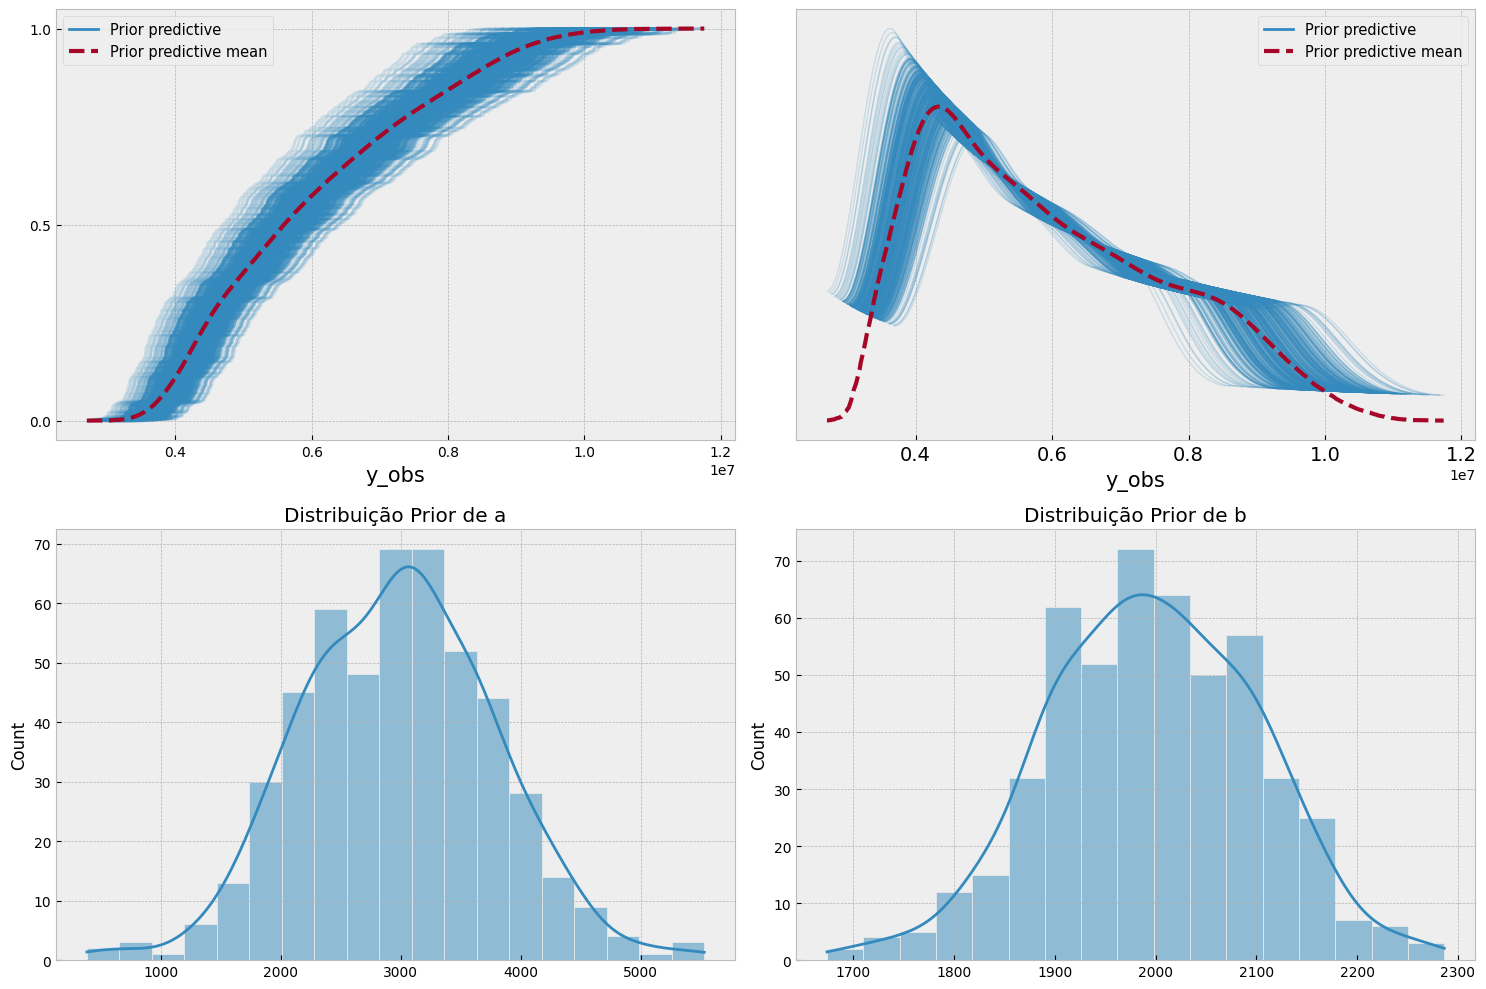

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

az.plot_ppc(tc_prior_sim, group='prior', kind='cumulative', ax=axes[0, 0])
az.plot_ppc(tc_prior_sim, group='prior', ax=axes[0, 1])
for i, param in enumerate(['a', 'b']):
    sns.histplot(tc_prior_sim.prior[param].values.flatten(), kde=True, ax=axes[1, i])
    axes[1, i].set_title(f'Distribuição Prior de {param}')

plt.tight_layout(); plt.show();

In [100]:
# Robusta
with pm.Model() as top_robust:
    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0,1)
    eps = pm.Normal("eps",0,1)
    df = pm.Exponential("df",1)
    likelihood = pm.StudentT("y_obs",nu=df,mu=a+b*t,sigma=eps,observed=obs_norm)

# Normal
with pm.Model() as top_norm:
    a = pm.Normal("a",0,1)
    b = pm.Normal("b",0,1)
    eps = pm.Normal("eps",0,1)
    likelihood = pm.Normal("y_obs",a+b*t,eps,observed=(obs-obs.mean())/obs.std())

# Lasso
with pm.Model() as top_lasso:
    a = pm.Laplace("a",0,1)
    b = pm.Laplace("b",0,1)
    eps = pm.Normal("eps",0,1)
    likelihood = pm.Normal("y_obs",a+b*t,eps,observed=(obs-obs.mean())/obs.std())

### Motivo do Uso do .fit()
> Após várias tentativas e a seleção de outras features, a ultima escolha foi utilizar o fit, que realiza a inferencia por métodos variacionais, que são uma aproximação ao método completo, e que eu posso usar no lugar de pm.sample() nesse caso.

Outra observação, resolvi fazer da maneira mais simples, e mesmo assim, obtive um resultado melhor, mas pela falta de tempo, optei pelo método mais rapido.

![](https://raw.githubusercontent.com/gabrielluizone/Predictive-Analysis/refs/heads/main/prints/Captura%20de%20tela%202024-09-26%20115610.png)

In [ ]:
with crop_model: trace_simp=pm.fit()
# apsar do erro, a variavel existe
# output: Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:01 Average Loss = 8.724e+09

In [110]:
trace_simp

In [109]:
with top_lasso: trace_lasso=pm.fit()

Output()

In [119]:
# Gerar amostras da aproximação
trace_simp1 = trace_simp.sample(1000)  # Gere 1000 amostras
trace_lasso1 = trace_lasso.sample(1000)  # Gere 1000 amostras

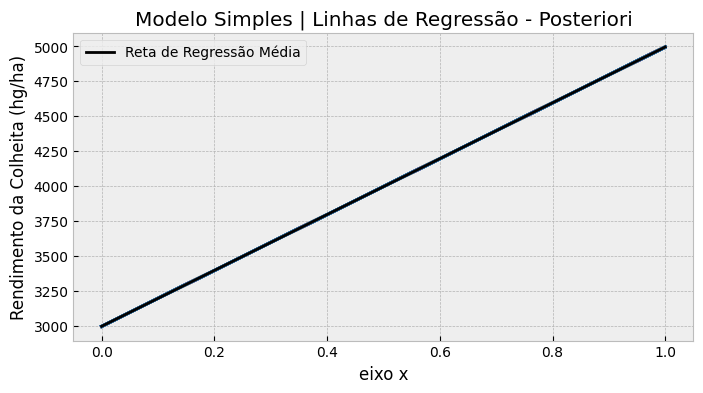

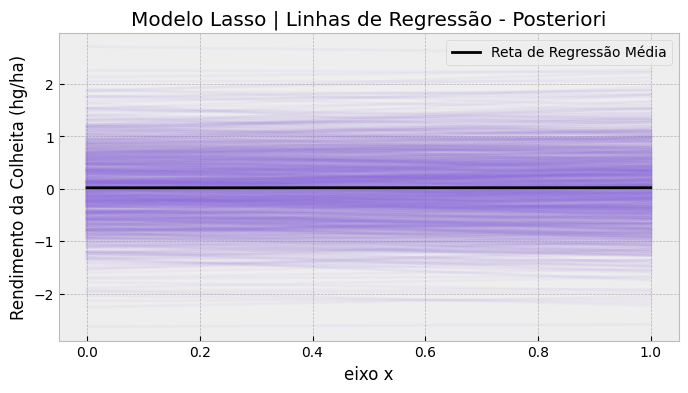

In [126]:
def plot_regression_lines(trace, plot_color="blue", t=np.linspace(0, 1, 100), alpha=0.05, mean_line_color="black", title='', xlabelt="eixo x"):
    # Certifique-se de que 'trace' é um objeto InferenceData
    if isinstance(trace, az.InferenceData):
        # Acesse os dados das variáveis a partir do InferenceData
        a_samples = trace.posterior['a'].values.flatten()  # 'a' do posterior
        b_samples = trace.posterior['b'].values.flatten()  # 'b' do posterior
    else:
        raise ValueError("O trace deve ser um objeto InferenceData.")

    plt.figure(figsize=(8, 4))
    for a_sample, b_sample in zip(a_samples, b_samples):
        plt.plot(t, a_sample + b_sample * t, color=plot_color, alpha=alpha)
    mean_a = np.mean(a_samples)
    mean_b = np.mean(b_samples)
    plt.plot(t, mean_a + mean_b * t, color=mean_line_color, label="Reta de Regressão Média")
    plt.xlabel(xlabelt)
    plt.ylabel("Rendimento da Colheita (hg/ha)")
    plt.title(f"{title} | Linhas de Regressão - Posteriori")
    plt.legend()
    plt.show()

# Usando a nova função
plot_regression_lines(trace_simp1, plot_color='steelblue', title='Modelo Simples')
plot_regression_lines(trace_lasso1, plot_color='mediumpurple', title='Modelo Lasso')

> Tems que a lasso, apresenta um area maior da faixa de incerteza

In [134]:
with crop_model: pm.compute_log_likelihood(trace_simp1)
with top_lasso: pm.compute_log_likelihood(trace_lasso1)

Output()

ValueError: ['log_likelihood'] group(s) already exists.

StopIteration: 

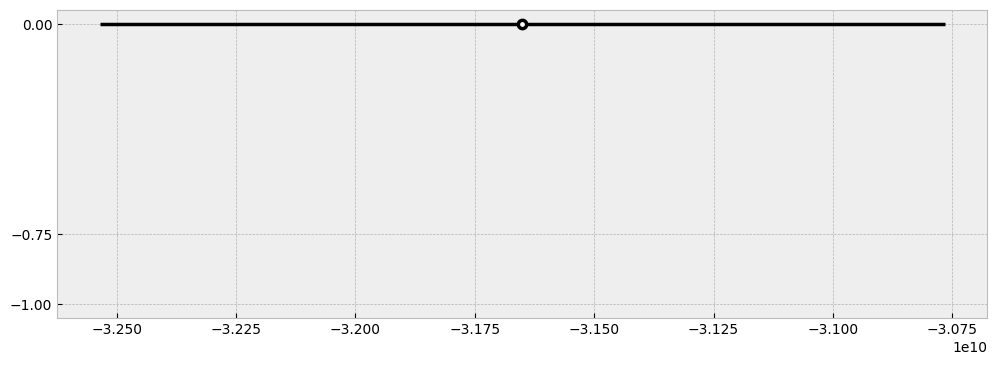

In [128]:
model_compare = az.compare({
    "Simples": trace_simp1,
    "Lasso": trace_lasso1,
}, method='BB-pseudo-BMA')

az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

> O plot acima mostra o desempenho do modelo simples, em relação ao lasso. Por algma razão, de ultima hora, ele não apareceu. Por essa razão, o modelo considerado o melhor, nesse contexto e nessas condições o Modelo Vencedor é de Regrssão Linear Simples. Em um caso de sucesso, haveria a avaliação das métricas do modelo, como a métrica ELPD LOO